In [1]:
import pandas as pd
import networkx as nx
from pathlib import Path

path = Path("20200315.csv")
df = pd.read_csv(path)
df.columns = [c.lower() for c in df.columns]

def find_col(names):
    for n in names:
        if n in df.columns:
            return n
    return None

col_uid   = find_col(["user_id", "userid", "user"])
col_uname = find_col(["username", "user_name", "author"])
col_pcid  = find_col(["parent_comment_user_id", "parent_comment_userid"])
col_psid  = find_col(["parent_submission_user_id", "parent_submission_userid"])
col_sub   = find_col(["subreddit", "sub", "community"])

if not col_uid or not col_uname or not col_sub:
    raise ValueError("Miss user_id / username / subreddit columns")

bad_ids = {"", "nan", "none", "null", "[deleted]", "[removed]", "n/a"}

def norm(x):
    try:
        return str(x).strip().lower()
    except:
        return ""

df["user_id"]          = df[col_uid].apply(norm)
df["parent_comment"]   = df[col_pcid].apply(norm)
df["parent_submission"] = df[col_psid].apply(norm)
df["sub"] = df[col_sub].apply(norm)

def pick_parent(row):
    for v in [row["parent_comment"], row["parent_submission"]]:
        if v and v not in bad_ids:
            return v
    return None

df["parent_user"] = df.apply(pick_parent, axis=1)

df = df[
    (~df["user_id"].isin(bad_ids)) &
    (df["parent_user"].notna()) &
    (~df["parent_user"].isin(bad_ids))
].copy()

id_to_name_df = df[[col_uid, col_uname]].copy()
id_to_name_df[col_uid]   = id_to_name_df[col_uid].apply(norm)
id_to_name_df[col_uname] = id_to_name_df[col_uname].apply(norm)

id_to_name_df = id_to_name_df[
    (~id_to_name_df[col_uid].isin(bad_ids)) &
    (~id_to_name_df[col_uname].isin(bad_ids))
]

id_to_name = dict(zip(id_to_name_df[col_uid], id_to_name_df[col_uname]))

def id_to_username(uid):
    return id_to_name.get(uid, uid)

edges = df[["user_id", "parent_user", "sub"]].copy()
edges["src"] = edges["user_id"].map(id_to_username)
edges["dst"] = edges["parent_user"].map(id_to_username)
edges = edges[edges["src"] != edges["dst"]]   

G = nx.Graph()

for src, dst, sub in edges[["src", "dst", "sub"]].itertuples(index=False, name=None):
    if G.has_edge(src, dst):
        G[src][dst].setdefault("subreddits", set()).add(sub)
    else:
        G.add_edge(src, dst, subreddits={sub})

print(f"Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

deg = pd.Series(dict(G.degree())).sort_values(ascending=False)



Graph built: 82465 nodes, 93553 edges


Final Nodes: 4227


C:\Users\william\AppData\Local\Temp\ipykernel_72944\1016432172.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(all_subs))


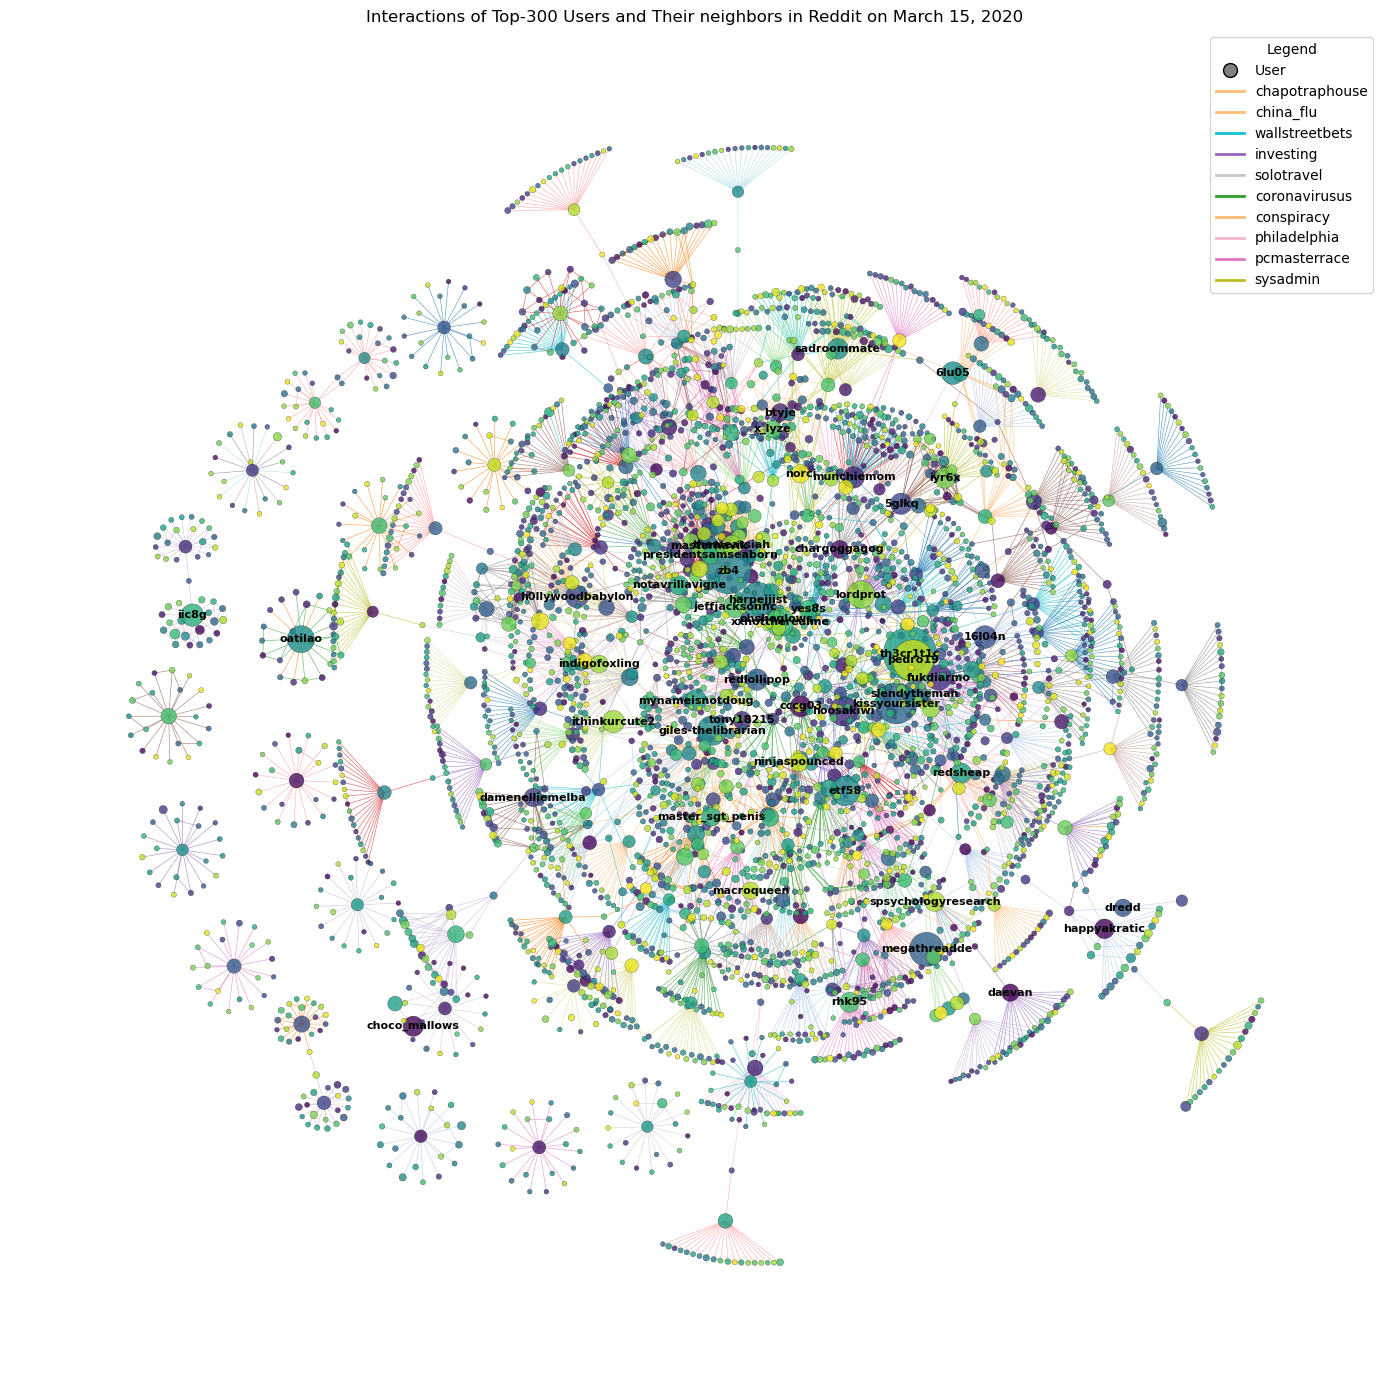

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import random
from matplotlib.lines import Line2D
from collections import Counter

top_k = 300
top_label_n = 50

top_k_nodes = set(deg.head(top_k).index)

H_temp = G.subgraph(top_k_nodes)
isolates = [n for n in H_temp.nodes() if H_temp.degree(n) == 0]

extra_nodes = set()
max_neighbors = 20 

for u in isolates:
    neighbors = list(G.neighbors(u))
    neighbors = sorted(neighbors, key=lambda x: deg.get(x, 0), reverse=True)
    extra_nodes.update(neighbors[:max_neighbors])

final_nodes = top_k_nodes.union(extra_nodes)
H = G.subgraph(final_nodes).copy()

components = list(nx.connected_components(H))
large_components = [c for c in components if len(c) > 2]
valid_nodes = set().union(*large_components)
H = H.subgraph(valid_nodes).copy()

for u, v, d in H.edges(data=True):
    strength = len(d['subreddits'])
    d['distance'] = 1.0 / strength 
    d['weight'] = strength

print(f"Final Nodes: {len(H)}")

components = list(nx.connected_components(H))
components.sort(key=len, reverse=True)

pos_local = {}
comp_radii = []

for i, comp in enumerate(components):
    subg = H.subgraph(comp)
    n_nodes = len(comp)
    
    radius = 500.0 * np.sqrt(n_nodes)
    comp_radii.append(radius)
    
    if n_nodes == 1:
        pos_sub = {list(comp)[0]: np.array([0.0, 0.0])}
    else:
        try:
            pos_sub = nx.kamada_kawai_layout(subg, weight='distance', scale=radius)
        except:
            pos_sub = nx.spring_layout(subg, weight='weight', scale=radius)
            
    center = np.mean(list(pos_sub.values()), axis=0)
    for n in pos_sub:
        pos_sub[n] = pos_sub[n] - center
        
    pos_local.update(pos_sub)

G_meta = nx.Graph()
dummy_center = -1 
G_meta.add_node(dummy_center)

for i in range(len(components)):
    G_meta.add_node(i)
    G_meta.add_edge(dummy_center, i, weight=0.05)

k_val = 5.0 / np.sqrt(len(components)) if len(components) > 0 else 1
pos_meta_raw = nx.spring_layout(G_meta, weight='weight', k=k_val, iterations=200, seed=42)

if dummy_center in pos_meta_raw:
    del pos_meta_raw[dummy_center]

total_scale = sum(comp_radii) * 0.2

pos_meta = {}
for k, v in pos_meta_raw.items():
    pos_meta[k] = v * total_scale

pos = {}
for i, comp in enumerate(components):
    center = pos_meta[i]
    for node in comp:
        pos[node] = pos_local[node] + center

sizes = [10 + 2.0 * deg.get(n, 0) for n in H.nodes()]

edge_widths = []
for u, v in H.edges():
    subs = G[u][v]["subreddits"]
    w = min(0.3 + 0.1 * len(subs), 2.0)
    edge_widths.append(w)

all_subs = sorted({s for _, _, d in H.edges(data=True) for s in d["subreddits"]})
cmap = cm.get_cmap("tab20", len(all_subs))
sub_to_color = {sub: cmap(i) for i, sub in enumerate(all_subs)}

edge_colors = []
edge_subs_used = [] # Track which sub is used for each edge to build legend
for u, v in H.edges():
    sub = list(G[u][v]["subreddits"])[0]
    edge_colors.append(sub_to_color.get(sub, "gray"))
    edge_subs_used.append(sub)

plt.figure(figsize=(14, 14), dpi=480)

nx.draw_networkx_nodes(
    H, pos,
    node_size=sizes,
    node_color=range(len(H)),
    cmap="viridis",
    alpha=0.8,
    edgecolors="black",
    linewidths=0.2
)

nx.draw_networkx_edges(
    H, pos,
    width=edge_widths,
    edge_color=edge_colors,
    alpha=0.8
)

label_nodes = list(deg.head(top_label_n).index)
labels = {n: n for n in H.nodes() if n in label_nodes}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=8, font_weight="bold")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='User',
           markerfacecolor='gray', markersize=10, markeredgecolor='black')
]

top_subs_counter = Counter(edge_subs_used).most_common(10)
for sub, count in top_subs_counter:
    color = sub_to_color.get(sub, "gray")
    legend_elements.append(
        Line2D([0], [0], color=color, lw=2, label=f'{sub}')
    )

plt.legend(handles=legend_elements, loc='upper right', title="Legend")

plt.title(f"Interactions of Top-{top_k} Users and Their neighbors in Reddit on March 15, 2020")
plt.axis("off")
plt.tight_layout()
plt.show()